### Features yg digunakan
['hotel', 'is_canceled', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces', 'total_of_special_requests']

# Model LOGIT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import accuracy_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier




In [2]:
df = pd.read_csv('hotel_bookings.csv')[:5000]
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0,5000.0,5000.0,5000.000000,4186.000000,292.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.459600,75.163600,2015.252400,31.467200,15.46720,1.205600,3.308000,1.969800,0.115600,0.014800,0.0,0.0,0.0,0.207200,209.089107,241.544521,1.772000,87.557872,0.093800,0.602000
std,0.498415,63.428176,0.434433,14.027497,9.15225,1.194158,2.503196,1.566326,0.444833,0.122409,0.0,0.0,0.0,0.612489,81.397565,79.612602,13.545358,50.278574,0.292948,0.823245
min,0.000000,0.000000,2015.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.000000,2015.000000,16.000000,7.00000,0.000000,1.750000,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,175.000000,223.000000,0.000000,50.400000,0.000000,0.000000
50%,0.000000,63.000000,2015.000000,34.000000,15.00000,1.000000,3.000000,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,240.000000,254.000000,0.000000,73.390000,0.000000,0.000000
75%,1.000000,111.000000,2016.000000,43.000000,24.00000,2.000000,5.000000,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,241.000000,281.000000,0.000000,117.815000,0.000000,1.000000
max,1.000000,737.000000,2016.000000,53.000000,31.00000,13.000000,33.000000,55.000000,10.000000,2.000000,0.0,0.0,0.0,17.000000,387.000000,383.000000,122.000000,332.000000,2.000000,4.000000


### dari sini kita bisa lihat feature mana saja yg memiliki data outlier

### kita bisa lihat bahwa banyak dataset yg outlier ke kanan (right skew):
* lead_time: adanya customer yg melalukan booking jauh2 hari dengan waktu booking lebih dari 2 tahun sebelum kedatangan, dimana customer pada umumnya booking pada kisaran waktu 111 hari sebelum tanggal kedatangan.
* stays_in_weekend_nights: adanya customer yg tinggal di hotel selama hari weekend dengan waktu stay lebih dari 13 hari, cimana pada umumnya customer hanya tinggal untuk 1-2 hari
* stays_in_week_nights: adanya customer yg tinggal di hotel selama hari weekdays dengan waktu stay lebih dari 33 hari, dimana pada umumnya customer hanya tinggal 3-5 hari
* adults: adanya jumlah booking/ stay dengan 1 booking untuk 55 orang, dimana pada biasanya 1 customer hanya akan booking untuk 2 orang
* children: adanya customer yg membawa 10 orang anak ketika menginap, dimana pada biasanya tidak ada customer yg membawa anak2
* babies: adanya customer yg membawa 2 bayi ketika menginap,  dimana pada biasanya tidak ada customer yg membawa bayi
* booking_changes: terdapatnya customer yg melakukan perubahaan booking sebanyak 17 kali hingga akhirnya dia menginap, dimana pada umumnya customer tidak melakukan perubaha booking sebelum akhirnya menginap
* days_in_waiting_list: adanya orang yg bersedia menunggu konfirmasi / menjadi waiting list dari suatu hotel hingga 122  hari lamanya, dimana pada umunya tidak ada customer yg mau menunggu selama itu. artinya, customer ini merupakan antusias/ fans dari hotel yg akan diinapinya
* adr: terdapatnya spending harian customer dengan biaya max 332k, 3x lipat lebih tinggi daripada pada umumnya spending hanya sekitar 117k
* required_car_parking_spaces: terdapatnya customer yg membutuhkan 2 parking spot ketika menginap
* total_of_special_requests: terdapatnya customer yg menuntut special request kepada hotel sebelum akhirnya menginap sejumlah max 4 special request, dimana pada umumnya customer lain tidak meminta special request apapun. kalaupun ada hanya 1 special request

### Outlier kita ketahui dengan melihat data 75% nya dan membandingkannya dengan data max




In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           5000 non-null   object 
 1   is_canceled                     5000 non-null   int64  
 2   lead_time                       5000 non-null   int64  
 3   arrival_date_year               5000 non-null   int64  
 4   arrival_date_month              5000 non-null   object 
 5   arrival_date_week_number        5000 non-null   int64  
 6   arrival_date_day_of_month       5000 non-null   int64  
 7   stays_in_weekend_nights         5000 non-null   int64  
 8   stays_in_week_nights            5000 non-null   int64  
 9   adults                          5000 non-null   int64  
 10  children                        5000 non-null   float64
 11  babies                          5000 non-null   int64  
 12  meal                            50

### dari sini kita bisa lihat bahwa dataset ini memiliki hampir 120k row dan 32 kolom

In [5]:
df.isna().sum()

hotel                                0
is_canceled                          0
lead_time                            0
arrival_date_year                    0
arrival_date_month                   0
arrival_date_week_number             0
arrival_date_day_of_month            0
stays_in_weekend_nights              0
stays_in_week_nights                 0
adults                               0
children                             0
babies                               0
meal                                 0
country                              2
market_segment                       0
distribution_channel                 0
is_repeated_guest                    0
previous_cancellations               0
previous_bookings_not_canceled       0
reserved_room_type                   0
assigned_room_type                   0
booking_changes                      0
deposit_type                         0
agent                              814
company                           4708
days_in_waiting_list     

### Disini kita bisa lihat kolom yg harus di drop karena missing value yg besar (agent, company) atau karena memang ga perlu dan ga bisa dicari tau (country, reservation_status, reservation_status_date) yakni:
* country
* agent
* company

In [6]:
df.drop(['country', 'agent', 'company', 'reservation_status', 'reservation_status_date'], axis=1, inplace=True)

In [7]:
df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64

In [8]:
df.isna().sum()/df.shape[0]*100

hotel                             0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
market_segment                    0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
assigned_room_type                0.0
booking_changes                   0.0
deposit_type                      0.0
days_in_waiting_list              0.0
customer_type                     0.0
adr                               0.0
required_car_parking_spaces       0.0
total_of_spe

### karena masih ada data yg kosong pada children, maka akan diisi dengan data rata2

In [9]:
df['children'].fillna(df['children'].mean(), inplace=True)

### Setelah kita ubah data kategorical menjadi data dummy agar dapat diproses

In [10]:
df=pd.get_dummies(df, drop_first=True)
df

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,2015,27,1,0,0,2,0.0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,737,2015,27,1,0,0,2,0.0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,7,2015,27,1,0,1,1,0.0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,13,2015,27,1,0,1,1,0.0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,14,2015,27,1,0,2,2,0.0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,212,2016,16,11,2,5,2,0.0,0,...,0,0,0,0,0,1,0,0,1,0
4996,1,212,2016,16,11,2,5,2,0.0,0,...,0,0,0,0,0,1,0,0,1,0
4997,1,212,2016,16,11,2,5,2,0.0,0,...,0,0,0,0,0,1,0,0,1,0
4998,1,212,2016,16,11,2,5,2,0.0,0,...,0,0,0,0,0,1,0,0,1,0


### Target kita adalah is_canceled, kita coba lihat dulu datanya

In [11]:
df['is_canceled'].value_counts()

0    2702
1    2298
Name: is_canceled, dtype: int64

### disini kita bisa lihat bahwa proporsi data yg cancel dan ga cancel bookingnya hampir setara. 
* 1 menyatakan cancel, dan 0 menyatakan tidak cancel. proporsi tidak cancel lebih bayak sedikit dibandingkan yg cancel

### kemudian kita pakai logit

In [12]:
df.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'arrival_date_month_August',
       'arrival_date_month_December', 'arrival_date_month_February',
       'arrival_date_month_January', 'arrival_date_month_July',
       'arrival_date_month_March', 'arrival_date_month_November',
       'arrival_date_month_October', 'arrival_date_month_September', 'meal_FB',
       'meal_HB', 'meal_SC', 'meal_Undefined', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA',
       'distribution_channel_Direct', 'distribution_channel_TA/T

### kita define x & y, fitur2 aman aja yg mau kita pakai

In [13]:


fitur = ['adults', 'children', 'babies', 'meal_FB', 'meal_HB', 'meal_SC', 'meal_Undefined', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups', 'market_segment_Offline TA/TO', 'market_segment_Online TA', 'distribution_channel_Direct', 'distribution_channel_TA/TO',
       'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E',
       'reserved_room_type_F', 'reserved_room_type_G', 'reserved_room_type_H',
       'reserved_room_type_L', 'reserved_room_type_P', 'assigned_room_type_B',
       'assigned_room_type_C', 'assigned_room_type_D', 'assigned_room_type_E',
       'assigned_room_type_F', 'assigned_room_type_G', 'assigned_room_type_H',
       'assigned_room_type_I', 'assigned_room_type_P',
       'deposit_type_Non Refund', 'deposit_type_Refundable',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'required_car_parking_spaces', 'total_of_special_requests']

target = ['is_canceled'] 

x = df[fitur]
y = df[target]

In [14]:
df2=df[['is_canceled','adults', 'children', 'babies', 'meal_FB', 'meal_HB', 'meal_SC', 'meal_Undefined', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups', 'market_segment_Offline TA/TO', 'market_segment_Online TA', 'distribution_channel_Direct', 'distribution_channel_TA/TO',
       'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E',
       'reserved_room_type_F', 'reserved_room_type_G', 'reserved_room_type_H',
       'reserved_room_type_L', 'reserved_room_type_P', 'assigned_room_type_B',
       'assigned_room_type_C', 'assigned_room_type_D', 'assigned_room_type_E',
       'assigned_room_type_F', 'assigned_room_type_G', 'assigned_room_type_H',
       'assigned_room_type_I', 'assigned_room_type_P',
       'deposit_type_Non Refund', 'deposit_type_Refundable',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'required_car_parking_spaces', 'total_of_special_requests']]

df2.corr()

,is_canceled,adults,children,babies,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Corporate,market_segment_Direct,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,required_car_parking_spaces,total_of_special_requests
is_canceled,1.000000,0.045200,0.024678,-0.029543,0.110654,0.031075,-0.041273,-0.082523,-0.036004,-0.106122,...,-0.000724,-0.074945,0.015336,0.298861,-0.074325,0.031350,0.164588,-0.124627,-0.295316,-0.083072
adults,0.045200,1.000000,0.009318,0.001288,0.002944,0.022462,-0.035229,0.001523,-0.080443,0.089885,...,0.031809,-0.013235,-0.017789,-0.013734,-0.004763,0.658572,-0.042870,-0.063202,-0.000365,-0.008082
children,0.024678,0.009318,1.000000,0.001637,-0.036570,-0.032026,-0.013772,-0.054688,-0.034713,0.092300,...,0.226658,0.003792,-0.003676,-0.082871,-0.025059,-0.005674,0.106991,-0.108133,0.051860,0.035530
babies,-0.029543,0.001288,0.001637,1.000000,-0.004822,0.034871,-0.006407,-0.025444,-0.006338,0.034027,...,-0.015517,-0.010440,-0.001710,-0.039268,-0.013549,-0.008572,0.034468,-0.026588,0.033799,0.175583
meal_FB,0.110654,0.002944,-0.036570,-0.004822,1.000000,-0.133538,-0.013833,-0.054931,-0.061264,-0.048307,...,-0.027017,-0.022540,-0.003692,0.313578,-0.029251,-0.018505,-0.093253,0.131406,-0.055658,-0.158107
meal_HB,0.031075,0.022462,-0.032026,0.034871,-0.133538,1.000000,-0.027106,-0.107639,-0.111177,-0.013749,...,-0.046105,-0.015389,-0.007235,0.129414,-0.057319,-0.015281,-0.069902,0.066180,-0.010560,-0.040314
meal_SC,-0.041273,-0.035229,-0.013772,-0.006407,-0.013833,-0.027106,1.000000,-0.011150,0.038613,0.003100,...,-0.006800,0.348727,0.266914,-0.017208,-0.005938,-0.003756,-0.063469,0.074534,-0.016968,-0.024958
meal_Undefined,-0.082523,0.001523,-0.054688,-0.025444,-0.054931,-0.107639,-0.011150,1.000000,-0.049382,-0.079022,...,-0.027002,-0.018169,-0.002976,0.029649,-0.023578,-0.014916,-0.280154,0.326191,-0.067382,-0.153887
market_segment_Corporate,-0.036004,-0.080443,-0.034713,-0.006338,-0.061264,-0.111177,0.038613,-0.049382,1.000000,-0.088132,...,-0.001625,0.011211,-0.003319,-0.076212,-0.026296,-0.016636,-0.223564,0.241855,-0.038315,-0.154151
market_segment_Direct,-0.106122,0.089885,0.092300,0.034027,-0.048307,-0.013749,0.003100,-0.079022,-0.088132,1.000000,...,0.028825,-0.025335,-0.005311,-0.121956,-0.042080,0.076763,0.121611,-0.121512,0.118314,0.011785


### disini kita bisa lihat bahwa:

### yg berkorelasi positif dengan is_canceled adalah feature:
* adults
* children
* meal_FB
* meal_HB
* market_segment_Groups
* market_segment_Online TA
* distribution_channel_TA/TO
* distribution_channel_TA/TO
* reserved_room_type_G
* reserved_room_type_H
* reserved_room_type_P
* assigned_room_type_P
* deposit_type_Non Refund	
* customer_type_Group
* customer_type_Transient

### yg berkorelasi positif dengan is_canceled adalah feature:
* yg ada di fitur namun selain diatas

### Kita juga bisa lihat korelasinya melalui heatmap

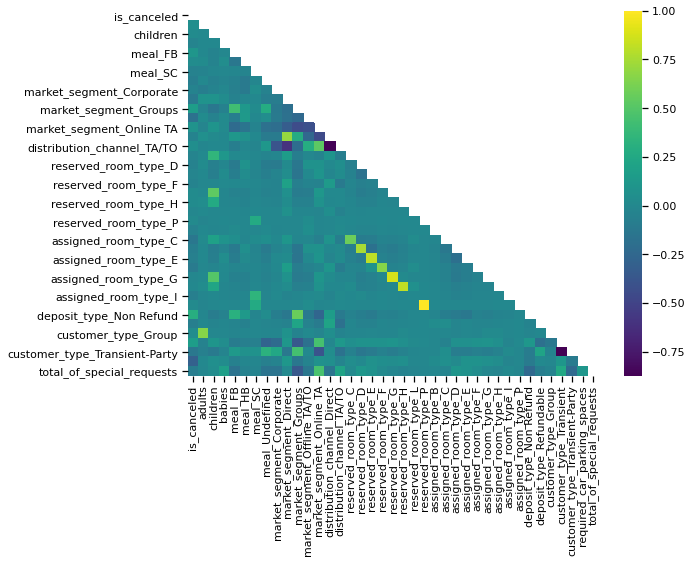

In [15]:
mask = np.zeros_like(df2.corr('pearson'))
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(10,8))
sns.set_context('notebook', font_scale=1)
sns.heatmap(df2.corr('pearson'), cmap='viridis', mask=mask, vmax=1)
plt.tight_layout()
plt.show()

### kemudian kita gunakan model logitnya

In [16]:
sm_logit = sm.Logit(y, sm.add_constant(x))
result = sm_logit.fit()

         Current function value: 0.499549
         Iterations: 35
C:\Users\adel.com\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### kita lihat hasilnya dan koefisiennya setiap featurenya

In [17]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4962
Method:                           MLE   Df Model:                           37
Date:                Mon, 08 Feb 2021   Pseudo R-squ.:                  0.2759
Time:                        11:03:36   Log-Likelihood:                -2497.7
converged:                      False   LL-Null:                       -3449.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.7362      0.813     -0.906      0.365      -2.330       0.857
adults                            0.1456      0.066      2.223      0.026 

### disini kita buang fitur yg p valuenya ga signifikan pada 10% alfa

In [25]:
fitur_baru= ['adults', 'children', 'babies', 'meal_Undefined', 'distribution_channel_Direct', 'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G', 'reserved_room_type_H', 'reserved_room_type_L', 'assigned_room_type_B', 'assigned_room_type_C', 'assigned_room_type_D', 'assigned_room_type_E', 'assigned_room_type_F', 'assigned_room_type_G', 'assigned_room_type_H','assigned_room_type_I', 'deposit_type_Non Refund', 'deposit_type_Refundable', 'customer_type_Transient', 'total_of_special_requests']
x = df[fitur_baru]

### disini features babies tetep dimasukin karena kecil kemungkinannya seseorang menginap tanpa membawa babiesnya, jadi babies tetap jadi faktor yg mempengaruhi seseorang untuk staycation ke hotel

### next kita run ulang modelnya


In [26]:
sm_logit = sm.Logit(y, sm.add_constant(x))
result = sm_logit.fit()

Optimization terminated successfully.
         Current function value: 0.569691
         Iterations 8


In [27]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4975
Method:                           MLE   Df Model:                           24
Date:                Mon, 08 Feb 2021   Pseudo R-squ.:                  0.1742
Time:                        11:16:51   Log-Likelihood:                -2848.5
converged:                       True   LL-Null:                       -3449.4
Covariance Type:            nonrobust   LLR p-value:                9.729e-239
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.4258      0.110     -3.888      0.000      -0.641      -0.211
adults                          0.1339      0.045      2.978      0.003       0.

### kemudian kita hitung VIF nya

In [28]:

def calc_vif (x):

    vif=pd.DataFrame()
    vif['variables']= x.columns
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

    return(vif)

calc_vif(x)

,variables,VIF
0,adults,2.019993
1,children,2.176520
2,babies,1.069758
3,meal_Undefined,1.058967
4,distribution_channel_Direct,1.450847
5,reserved_room_type_C,1.860422
6,reserved_room_type_D,3.131777
7,reserved_room_type_E,4.124835
8,reserved_room_type_F,2.050958
9,reserved_room_type_G,5.441777


### dari VIF nya kita bisa simpulkan bahwa ga ada multikolineatiry antar features yg udah terpilih, walaupun ada yg vifnya diatas 4 tapi karena masih dekat jadi dianggap wajar

### kita cek koefisien tiap variabel, ga semuanya dijabarin, beberapa contoh aja:
* kalau ada customer yg booking untuk reserved_room_type_C sebesar 1 unit, maka kemungkinan orang tersebut untuk cancelnya meningkat sebesar 1.8523 unit
* kalau ada customer yang tidak menentukan mela / meal_Undefined sebesar 1 unit, maka kemungkinan orang tersebut untuk cancelnya berkurang sebesar 1.2253 unit

### next kita lakukan validasi. pertama kita bagi datanya jadi 2, train & test.

In [30]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    stratify = y, 
    test_size = 0.2,
    random_state = 2020
)

### kemudian disini kita ngebuat model berdasarkan data train yg udah kita pisah di cell2 sebelumnya
 


In [32]:
sm_logit_train = sm.Logit(y_train, sm.add_constant (x_train))
result_train = sm_logit_train.fit()

         Current function value: 0.568746
         Iterations: 35
C:\Users\adel.com\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### next kita mau ngelakuin uji coba prediksi dengan menggunakan data test



In [34]:
y_predict_proba = result_train.predict(sm.add_constant(x_test)) # memprediksi hasil probability (y_test) dari X test

y_predict_class = np.where(y_predict_proba>0.5, 1, 0) # prediksi yg hasil probabilitynya diatas 50%, akan masuk ke kategori default=1. kalau probability nya dibawah 50%, maka akan masuk kategori default = 0

y_predict_proba

4097    0.456719
1166    0.539248
1674    0.310752
1060    0.272626
1358    0.500016
          ...   
1662    0.519545
4414    0.544890
964     0.161313
3294    0.392524
2141    0.946002
Length: 1000, dtype: float64

### kemudian disini kita bisa lihat hasil bersih dari outputnya.



In [35]:
y_predict_class

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

### terakhir kita melakukan analisa akurasi



In [37]:
print('model accuracy in test dataset: ', accuracy_score(y_test, y_predict_class))

model accuracy in test dataset:  0.665


### Kesimpulan dari model LOGIT
* Model kita dapat memprediksi CANCEL / TIDAK CANCEL nya seseorang secara benar sebesar 66% (6 dari 10 orang) 
* ACCURACY adalah TOTAL PREDIKSI YG BENAR / TOTAL DATA

# Model KNN

In [40]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt  
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

### load data lagi biar ga salah & kecampur

In [42]:
df = pd.read_csv('hotel_bookings.csv')[:5000]
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### sama aja kaya yg logit pertama, liat deskriptif statistiknya

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           5000 non-null   object 
 1   is_canceled                     5000 non-null   int64  
 2   lead_time                       5000 non-null   int64  
 3   arrival_date_year               5000 non-null   int64  
 4   arrival_date_month              5000 non-null   object 
 5   arrival_date_week_number        5000 non-null   int64  
 6   arrival_date_day_of_month       5000 non-null   int64  
 7   stays_in_weekend_nights         5000 non-null   int64  
 8   stays_in_week_nights            5000 non-null   int64  
 9   adults                          5000 non-null   int64  
 10  children                        5000 non-null   float64
 11  babies                          5000 non-null   int64  
 12  meal                            50

In [45]:
df.isna().sum()

hotel                                0
is_canceled                          0
lead_time                            0
arrival_date_year                    0
arrival_date_month                   0
arrival_date_week_number             0
arrival_date_day_of_month            0
stays_in_weekend_nights              0
stays_in_week_nights                 0
adults                               0
children                             0
babies                               0
meal                                 0
country                              2
market_segment                       0
distribution_channel                 0
is_repeated_guest                    0
previous_cancellations               0
previous_bookings_not_canceled       0
reserved_room_type                   0
assigned_room_type                   0
booking_changes                      0
deposit_type                         0
agent                              814
company                           4708
days_in_waiting_list     

In [46]:
df.drop(['country', 'agent', 'company', 'reservation_status', 'reservation_status_date'], axis=1, inplace=True)

In [47]:
df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64

In [48]:
df=pd.get_dummies(df, drop_first=True)
df

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,2015,27,1,0,0,2,0.0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,737,2015,27,1,0,0,2,0.0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,7,2015,27,1,0,1,1,0.0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,13,2015,27,1,0,1,1,0.0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,14,2015,27,1,0,2,2,0.0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,212,2016,16,11,2,5,2,0.0,0,...,0,0,0,0,0,1,0,0,1,0
4996,1,212,2016,16,11,2,5,2,0.0,0,...,0,0,0,0,0,1,0,0,1,0
4997,1,212,2016,16,11,2,5,2,0.0,0,...,0,0,0,0,0,1,0,0,1,0
4998,1,212,2016,16,11,2,5,2,0.0,0,...,0,0,0,0,0,1,0,0,1,0


### define features

In [49]:
fitur = ['adults', 'children', 'babies', 'meal_FB', 'meal_HB', 'meal_SC', 'meal_Undefined', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups', 'market_segment_Offline TA/TO', 'market_segment_Online TA', 'distribution_channel_Direct', 'distribution_channel_TA/TO',
       'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E',
       'reserved_room_type_F', 'reserved_room_type_G', 'reserved_room_type_H',
       'reserved_room_type_L', 'reserved_room_type_P', 'assigned_room_type_B',
       'assigned_room_type_C', 'assigned_room_type_D', 'assigned_room_type_E',
       'assigned_room_type_F', 'assigned_room_type_G', 'assigned_room_type_H',
       'assigned_room_type_I', 'assigned_room_type_P',
       'deposit_type_Non Refund', 'deposit_type_Refundable',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'required_car_parking_spaces', 'total_of_special_requests']

target = ['is_canceled'] 

x = df[fitur]
y = df[target]

### split data

In [51]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    stratify = y, 
    test_size = 0.2,
    random_state = 2020
)

### buat model prediksi knn

In [53]:
knn = KNeighborsClassifier(n_neighbors=3) # menentukan ada berapa tetangga yg mau kita cocokin
knn.fit(x_train, y_train)
y_predict_class=knn.predict(x_test)

In [54]:
print('model accuracy in test dataset:', accuracy_score(y_test,y_predict_class))

model accuracy in test dataset: 0.707


### Kesimpulan 1 dari model KNN
* Model kita dapat memprediksi CANCEL / TIDAK CANCEL nya seseorang secara benar sebesar 70.7% (7 dari 10 orang) 
* akurasi model ningkat 10%, dari yg tadinya 60%an jadi 70%
* ACCURACY adalah TOTAL PREDIKSI YG BENAR / TOTAL DATA

### next kita scaling

In [57]:
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scaled=scaler.transform(x_train)
x_test_scaled=scaler.transform(x_test)

In [58]:
knn= KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_scaled, y_train)
y_predict_class=knn.predict(x_test_scaled)

In [59]:
print('model accuracy in test dataset:', accuracy_score(y_test,y_predict_class))

model accuracy in test dataset: 0.715


### Kesimpulan 2 dari model KNN
* Model kita dapat memprediksi CANCEL / TIDAK CANCEL nya seseorang secara benar sebesar 71.5% (7 dari 10 orang) 
* akurasi model ningkat 1%
* ACCURACY adalah TOTAL PREDIKSI YG BENAR / TOTAL DATA

# Decision Tree

In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

### sama aja kaya sebelumnya

In [307]:
df = pd.read_csv('hotel_bookings.csv')[:5000]
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [308]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0,5000.0,5000.0,5000.000000,4186.000000,292.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.459600,75.163600,2015.252400,31.467200,15.46720,1.205600,3.308000,1.969800,0.115600,0.014800,0.0,0.0,0.0,0.207200,209.089107,241.544521,1.772000,87.557872,0.093800,0.602000
std,0.498415,63.428176,0.434433,14.027497,9.15225,1.194158,2.503196,1.566326,0.444833,0.122409,0.0,0.0,0.0,0.612489,81.397565,79.612602,13.545358,50.278574,0.292948,0.823245
min,0.000000,0.000000,2015.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.000000,2015.000000,16.000000,7.00000,0.000000,1.750000,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,175.000000,223.000000,0.000000,50.400000,0.000000,0.000000
50%,0.000000,63.000000,2015.000000,34.000000,15.00000,1.000000,3.000000,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,240.000000,254.000000,0.000000,73.390000,0.000000,0.000000
75%,1.000000,111.000000,2016.000000,43.000000,24.00000,2.000000,5.000000,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,241.000000,281.000000,0.000000,117.815000,0.000000,1.000000
max,1.000000,737.000000,2016.000000,53.000000,31.00000,13.000000,33.000000,55.000000,10.000000,2.000000,0.0,0.0,0.0,17.000000,387.000000,383.000000,122.000000,332.000000,2.000000,4.000000


In [309]:
df.describe(include = object)

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date
count,5000,5000,5000,4998,5000,5000,5000,5000,5000,5000,5000,5000
unique,1,10,5,56,6,3,9,10,3,4,3,359
top,Resort Hotel,July,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-10-10
freq,5000,842,3418,3174,2156,3657,3167,2537,4461,3699,2702,70


In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           5000 non-null   object 
 1   is_canceled                     5000 non-null   int64  
 2   lead_time                       5000 non-null   int64  
 3   arrival_date_year               5000 non-null   int64  
 4   arrival_date_month              5000 non-null   object 
 5   arrival_date_week_number        5000 non-null   int64  
 6   arrival_date_day_of_month       5000 non-null   int64  
 7   stays_in_weekend_nights         5000 non-null   int64  
 8   stays_in_week_nights            5000 non-null   int64  
 9   adults                          5000 non-null   int64  
 10  children                        5000 non-null   float64
 11  babies                          5000 non-null   int64  
 12  meal                            50

In [311]:
df.isna().sum()

hotel                                0
is_canceled                          0
lead_time                            0
arrival_date_year                    0
arrival_date_month                   0
arrival_date_week_number             0
arrival_date_day_of_month            0
stays_in_weekend_nights              0
stays_in_week_nights                 0
adults                               0
children                             0
babies                               0
meal                                 0
country                              2
market_segment                       0
distribution_channel                 0
is_repeated_guest                    0
previous_cancellations               0
previous_bookings_not_canceled       0
reserved_room_type                   0
assigned_room_type                   0
booking_changes                      0
deposit_type                         0
agent                              814
company                           4708
days_in_waiting_list     

### lihat proporsi data kosongnya berapa dari setiap variabel.

In [312]:
df.isnull().sum()/df.shape[0]*100

hotel                              0.00
is_canceled                        0.00
lead_time                          0.00
arrival_date_year                  0.00
arrival_date_month                 0.00
arrival_date_week_number           0.00
arrival_date_day_of_month          0.00
stays_in_weekend_nights            0.00
stays_in_week_nights               0.00
adults                             0.00
children                           0.00
babies                             0.00
meal                               0.00
country                            0.04
market_segment                     0.00
distribution_channel               0.00
is_repeated_guest                  0.00
previous_cancellations             0.00
previous_bookings_not_canceled     0.00
reserved_room_type                 0.00
assigned_room_type                 0.00
booking_changes                    0.00
deposit_type                       0.00
agent                             16.28
company                           94.16


### variabel company punya proporsi data kosong terbesar, disusul variabel agent

### replace missing value

In [313]:
df.replace('?',np.nan,inplace = True)

### milih preprocess scheme:
* one hot encoding : distribution channel, deposit type, customer type
* binary encoding :  meal,  market segment, reserved room, assigned room, 
* ordinal encoding : -
* no treatment : sisanya

### disini yg dipilih untuk di one hot encoding itu yg variabelnya max 3. yg binary encoding yg variabelnya diatas 3. acuan ke pdf kelas

In [314]:
binary_encoder_pipeline = Pipeline([
                                    ('imputer',SimpleImputer(strategy = 'constant',fill_value = 'NC')),
                                    ('binary encoder',ce.BinaryEncoder())
])

transformer = ColumnTransformer([
                                 ('one hot encoder',OneHotEncoder(drop = 'first'),[ 'arrival_date_year', 'distribution_channel','deposit_type',   'customer_type']),
                                 ('binary encoder',binary_encoder_pipeline,['arrival_date_month','arrival_date_day_of_month','meal','market_segment','reserved_room_type','assigned_room_type'])
                                ], remainder = 'passthrough')

### kemudian define variabel independen dan dependen

### next kita split

In [315]:
fitur = ['lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests']

target = ['is_canceled'] 

x = df[fitur]
y = df[target]

In [316]:
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x,
    y,
    stratify = y, 
    random_state = 2020
)

### data di transform

In [317]:
x_train_val_preprocessed=transformer.fit_transform(x_train_val)
x_test_preprocessed= transformer.transform(x_test)

In [318]:
x_train_val_preprocessed = pd.DataFrame(x_train_val_preprocessed)
x_test_preprocessed = pd.DataFrame(x_test_preprocessed)
x_train_val_preprocessed

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.00,0.0,2.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.00,0.0,2.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.45,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.00,0.0,0.0
4,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.30,0.0,0.0
3746,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.00,0.0,0.0
3747,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.00,0.0,0.0
3748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.00,0.0,0.0


In [319]:
transformer.transformers_

[('one hot encoder',
  OneHotEncoder(drop='first'),
  ['arrival_date_year',
   'distribution_channel',
   'deposit_type',
   'customer_type']),
 ('binary encoder',
  Pipeline(steps=[('imputer',
                   SimpleImputer(fill_value='NC', strategy='constant')),
                  ('binary encoder', BinaryEncoder())]),
  ['arrival_date_month',
   'arrival_date_day_of_month',
   'meal',
   'market_segment',
   'reserved_room_type',
   'assigned_room_type']),
 ('remainder',
  'passthrough',
  [0, 3, 5, 6, 7, 8, 9, 13, 14, 15, 18, 20, 22, 23, 24])]

In [320]:
transformer.transformers_[0][1].get_feature_names()

array(['x0_2016', 'x1_Direct', 'x1_TA/TO', 'x2_Non Refund',
       'x2_Refundable', 'x3_Group', 'x3_Transient', 'x3_Transient-Party'],
      dtype=object)

In [321]:
transformer.transformers_[1][1]['binary encoder'].get_feature_names()

['0_0',
 '0_1',
 '0_2',
 '0_3',
 '0_4',
 '1_0',
 '1_1',
 '1_2',
 '1_3',
 '1_4',
 '1_5',
 '2_0',
 '2_1',
 '2_2',
 '2_3',
 '3_0',
 '3_1',
 '3_2',
 '3_3',
 '4_0',
 '4_1',
 '4_2',
 '4_3',
 '4_4',
 '5_0',
 '5_1',
 '5_2',
 '5_3',
 '5_4']

In [322]:
features = list(transformer.transformers_[0][1].get_feature_names()) + transformer.transformers_[1][1]['binary encoder'].get_feature_names() + ['is_canceled',	'lead_time','arrival_date_year','arrival_date_week_number',	'arrival_date_day_of_month', 'adults',	'children',	'babies',	'is_repeated_guest',	'previous_cancellations',	'booking_changes', 'days_in_waiting_list',	'adr',	'required_car_parking_spaces',	'total_of_special_requests']
x_train_val_preprocessed.columns = features
x_test_preprocessed.columns = features
x_train_val_preprocessed

,x0_2016,x1_Direct,x1_TA/TO,x2_Non Refund,x2_Refundable,x3_Group,x3_Transient,x3_Transient-Party,0_0,0_1,...,adults,children,babies,is_repeated_guest,previous_cancellations,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.00,0.0,2.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.00,0.0,2.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.45,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.00,0.0,0.0
4,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.30,0.0,0.0
3746,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.00,0.0,0.0
3747,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.00,0.0,0.0
3748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.00,0.0,0.0


### lakukan model fitting & evaluation: decision tree

In [323]:
model = DecisionTreeClassifier(max_depth = 3)
model.fit(x_train_val_preprocessed, y_train_val)

DecisionTreeClassifier(max_depth=3)

In [324]:
y_pred = model.predict(x_test_preprocessed)
print('classification_report:',classification_report(y_test,y_pred))

classification_report:               precision    recall  f1-score   support

           0       0.65      0.93      0.76       676
           1       0.84      0.40      0.54       574

    accuracy                           0.69      1250
   macro avg       0.74      0.67      0.65      1250
weighted avg       0.73      0.69      0.66      1250



### model properties

In [325]:
importance_table = pd.DataFrame({
    'imp':model.feature_importances_
}, index = features)

In [326]:
importance_table

,imp
x0_2016,0.000000
x1_Direct,0.000000
x1_TA/TO,0.000000
x2_Non Refund,0.171063
x2_Refundable,0.000000
x3_Group,0.000000
x3_Transient,0.082926
x3_Transient-Party,0.000000
0_0,0.000000
0_1,0.000000


<AxesSubplot:>

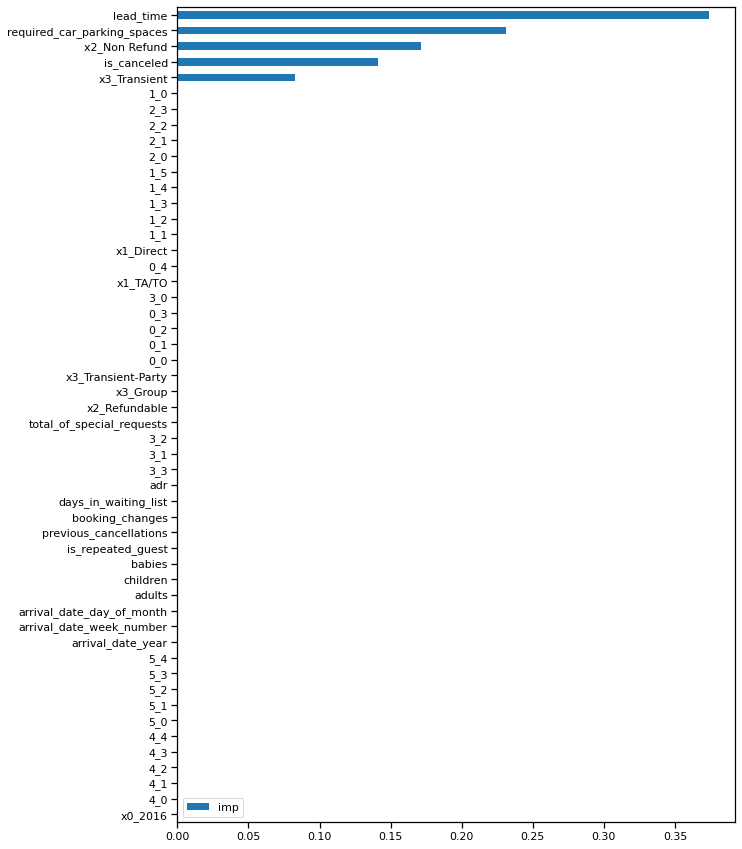

In [327]:
importance_table.sort_values(by = 'imp').plot(kind = 'barh', figsize = (10,15))

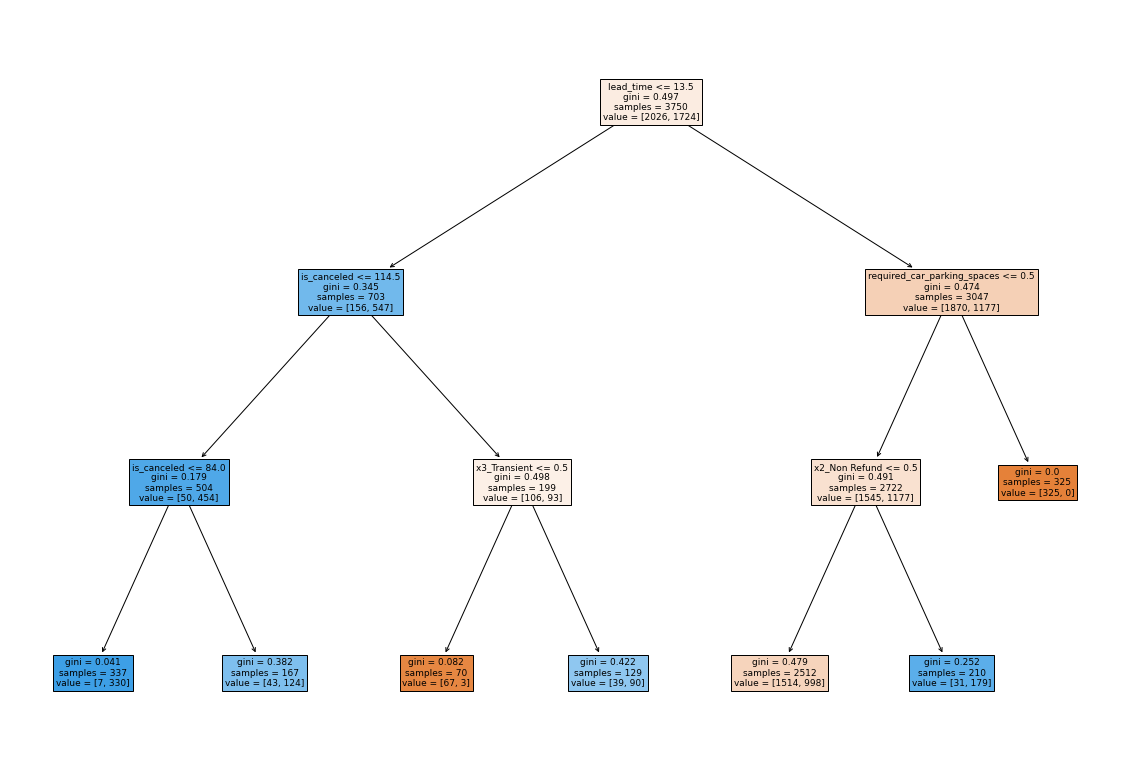

In [328]:
plt.figure(figsize = (20,14))
plot_tree(model, feature_names = features,filled = True)
plt.show()

# Ensemble model

In [329]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, f1_score,recall_score, precision_score

In [330]:
df = pd.read_csv('hotel_bookings.csv')[:5000]
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [331]:
df.drop(['country', 'agent', 'company', 'reservation_status', 'reservation_status_date'], axis=1, inplace=True)

In [332]:
df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64

### preprocess

In [333]:
binary_encoder_pipeline = Pipeline([
                                    ('imputer',SimpleImputer(strategy = 'constant',fill_value = 'NC')),
                                    ('binary encoder',ce.BinaryEncoder())
])

transformer = ColumnTransformer([
                                 ('one hot encoder',OneHotEncoder(drop = 'first'),[ 'arrival_date_year', 'distribution_channel','deposit_type','customer_type']),
                                 ('binary encoder',binary_encoder_pipeline,['arrival_date_month','arrival_date_day_of_month','meal','market_segment','reserved_room_type','assigned_room_type'])
                                ], remainder = 'passthrough')

### define x, y dan split

fitur = ['lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests']

target = ['is_canceled'] 

x = df[fitur]
y = df[target]

In [334]:
fitur = ['lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
    'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests']

target = ['is_canceled'] 

x = df[fitur]
y = df[target]

In [335]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    stratify = y, # stratified random sampling
    test_size = 0.2, 
    random_state = 2020) # make the result consistent

### standalone model

In [336]:
lr=LogisticRegression()
dt=DecisionTreeClassifier(max_depth=5)
knn=KNeighborsClassifier(n_neighbors=3)

In [337]:
zip([lr,dt,knn],['Logistic Regression','Decision Tree','KNN'])
# The zip() function returns a zip object, which is an iterator of tuples where the first item in each passed iterator is paired together, and then the second item in each passed iterator are paired together etc.

In [338]:
# mentok, tulisannya: ValueError: could not convert string to float: 'September'

for clfs, clf_name in zip([lr,dt,knn],['Logistic Regression','Decision Tree','KNN']):
  clfs.fit(x_train, y_train)
  y_pred = clfs.predict(x_test)
  print(clf_name+":")
  print(classification_report(y_test,y_pred))

ValueError: could not convert string to float: 'September'

In [339]:
models={'logistic regression': LogisticRegression(),
    'decision tree': DecisionTreeClassifier(max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=3)}
score=[]

for i in models:
    models[i].fit(x_train,y_train)
    y_pred=models[i].predict(x_test)
    score.append([precision_score(y_test,y_pred),recall_score(y_test,y_pred),f1_score(y_test,y_pred)])

df_score=pd.DataFrame(score, columns= ['Precision','Recall','F1 score'], index=models.keys())
df_score


ValueError: could not convert string to float: 'September'

In [340]:
lr=LogisticRegression()
df=DecisionTreeClassifier(max_depth=5)
knn=KNeighborsClassifier(n_neighbors=3)

vc= VotingClassifier([('clf1',lr),('clf2',dt),('clf3',knn)],voting='soft')

In [341]:
vc.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [342]:
y_pred_soft = vc.predict(x_test)

NotFittedError: This VotingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [343]:
print(classification_report(y_test,y_pred_soft))

NameError: name 'y_pred_soft' is not defined

In [344]:
df_score

NameError: name 'df_score' is not defined